# Import Libraries and CSV Data

This notebook inlcudes all features except some that didn't contribute any information, these are pointed out below

In [23]:
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from scipy.sparse import hstack
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

file_path = 'data/english_video_data.csv'
videos_df = pd.read_csv(file_path)
videos_df.head(5)

,c_channel_id,v_video_id,v_date_publishedAt,v_time_publishedAt,c_channel_title,c_channel_upload_playlist,c_channel_subCount,c_channel_videoCount,c_channel_viewCount,v_category_id,...,v_comment_count,v_likes,v_favorites,v_views,v_definition,v_duration,v_caption,v_age_restricted,v_privacy_status,v_made_for_kids
0,UC295-Dw_tDNtZXFeAPAW6Aw,oGga7hZypCs,2024-09-02,11:00:48,5-Minute Crafts,UU295-Dw_tDNtZXFeAPAW6Aw,81100000,7445,27960945663,26,...,28,442,0,76602,hd,2:03:35,False,Not Restricted,public,False
1,UC295-Dw_tDNtZXFeAPAW6Aw,pkzIiXkRxB0,2024-08-30,11:00:54,5-Minute Crafts,UU295-Dw_tDNtZXFeAPAW6Aw,81100000,7445,27960945663,26,...,21,1165,0,341133,hd,2:01:48,False,Not Restricted,public,False
2,UC295-Dw_tDNtZXFeAPAW6Aw,TUS8vZaHNds,2024-08-31,11:00:26,5-Minute Crafts,UU295-Dw_tDNtZXFeAPAW6Aw,81100000,7445,27960945663,26,...,43,1374,0,222425,hd,1:00:04,False,Not Restricted,public,False
3,UC295-Dw_tDNtZXFeAPAW6Aw,rBzKTkUG3Wk,2024-08-31,13:00:57,5-Minute Crafts,UU295-Dw_tDNtZXFeAPAW6Aw,81100000,7445,27960945663,26,...,19,274,0,40821,hd,1:01:09,False,Not Restricted,public,False
4,UC295-Dw_tDNtZXFeAPAW6Aw,XHQP6mut8YI,2024-09-01,11:00:36,5-Minute Crafts,UU295-Dw_tDNtZXFeAPAW6Aw,81100000,7445,27960945663,26,...,27,485,0,82374,hd,0:20:16,False,Not Restricted,public,False


# Data Preprocessing

In [24]:
# Remove some columns that we wont need in this model
videos_df_2 = videos_df.drop(['v_favorites','v_privacy_status','c_channel_id','v_video_id','c_channel_upload_playlist','v_description'], axis=1)

In [25]:
videos_df_2.dtypes

v_date_publishedAt      object
v_time_publishedAt      object
c_channel_title         object
c_channel_subCount       int64
c_channel_videoCount     int64
c_channel_viewCount      int64
v_category_id            int64
v_tags                  object
v_title                 object
v_comment_count          int64
v_likes                  int64
v_views                  int64
v_definition            object
v_duration              object
v_caption                 bool
v_age_restricted        object
v_made_for_kids           bool
dtype: object

In [26]:
# Change the way duration, date published, and time published are formatted
videos_df_2['v_date_publishedAt'] = videos_df_2['v_date_publishedAt'].astype('datetime64[s]')
videos_df_2['v_time_publishedAt'] = videos_df_2['v_time_publishedAt'].astype('datetime64[s]')

videos_df_2['v_year'] = videos_df_2['v_date_publishedAt'].dt.year
videos_df_2['v_month'] = videos_df_2['v_date_publishedAt'].dt.month
videos_df_2['v_day'] = videos_df_2['v_date_publishedAt'].dt.day
videos_df_2['v_hour'] = videos_df_2['v_time_publishedAt'].dt.hour
videos_df_2['v_minute'] = videos_df_2['v_time_publishedAt'].dt.minute
videos_df_2['v_second'] = videos_df_2['v_time_publishedAt'].dt.second

videos_df_2.drop(['v_date_publishedAt', 'v_time_publishedAt'], axis=1, inplace=True)

videos_df_2['v_duration_time'] = pd.to_timedelta(videos_df_2['v_duration'])

videos_df_2['v_duration_time'] = videos_df_2['v_duration_time'].dt.total_seconds()

videos_df_2.drop(['v_duration'], axis=1, inplace=True)

In [27]:
videos_df_2.dtypes

c_channel_title          object
c_channel_subCount        int64
c_channel_videoCount      int64
c_channel_viewCount       int64
v_category_id             int64
v_tags                   object
v_title                  object
v_comment_count           int64
v_likes                   int64
v_views                   int64
v_definition             object
v_caption                  bool
v_age_restricted         object
v_made_for_kids            bool
v_year                    int32
v_month                   int32
v_day                     int32
v_hour                    int32
v_minute                  int32
v_second                  int32
v_duration_time         float64
dtype: object

In [28]:
# list of all category names from Youtube with their ID's
categories = {
    1: "Film & Animation",
    2: "Autos & Vehicles",
    10: "Music",
    15: "Pets & Animals",
    17: "Sports",
    18: "Short Movies",
    19: "Travel & Events",
    20: "Gaming",
    21: "Videoblogging",
    22: "People & Blogs",
    23: "Comedy",
    24: "Entertainment",
    25: "News & Politics",
    26: "Howto & Style",
    27: "Education",
    28: "Science & Technology",
    29: "Nonprofits & Activism",
    30: "Movies",
    31: "Anime/Animation",
    32: "Action/Adventure",
    33: "Classics",
    34: "Comedy",
    35: "Documentary",
    36: "Drama",
    37: "Family",
    38: "Foreign",
    39: "Horror",
    40: "Sci-Fi/Fantasy",
    41: "Thriller",
    42: "Shorts",
    43: "Shows",
    44: "Trailers"
}

In [29]:
# Function to change category id to the category name
def name_categories(df, category_dict):
    for index, row in df.iterrows():
        if row['v_category_id'] in [23, 10, 17, 15, 19]:
            df.at[index, 'v_category_id'] = "other"
        elif row['v_category_id'] in category_dict:
            df.at[index, 'v_category_id'] = category_dict[row['v_category_id']]

    return df

In [30]:
# Uses function above to change category
videos_df_cats = name_categories(videos_df_2, categories)

C:\Users\amy_d\AppData\Local\Temp\ipykernel_25292\919998033.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Howto & Style' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[index, 'v_category_id'] = category_dict[row['v_category_id']]


In [31]:
# This will randomize the order of our datafram since the CSV that was read in was sorted

videos_df_cats = videos_df_cats.sample(frac=1, random_state=42).reset_index(drop=True)

In [32]:
videos_df_cats.columns

Index(['c_channel_title', 'c_channel_subCount', 'c_channel_videoCount',
       'c_channel_viewCount', 'v_category_id', 'v_tags', 'v_title',
       'v_comment_count', 'v_likes', 'v_views', 'v_definition', 'v_caption',
       'v_age_restricted', 'v_made_for_kids', 'v_year', 'v_month', 'v_day',
       'v_hour', 'v_minute', 'v_second', 'v_duration_time'],
      dtype='object')

In [33]:
# Get dummies for certain columns
videos_df_dummies = pd.get_dummies(data= videos_df_cats, columns=['v_category_id','v_definition','v_caption','v_age_restricted','v_made_for_kids'],dtype=int)

In [34]:
# Function to bucket our views column for our models to use as target(y)
def bucket_views(df, column_name):
    bins = [-1, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, float("inf")]
    labels = [
        "Very Low (0 - 1K)",
        "Low (1K - 5K)",
        "Moderate (5K - 10K)",
        "Growing (10K - 50K)",
        "Established (50K - 100K)",
        "Popular (100K - 500K)",
        "Trending (500K - 1M)",
        "Viral (1M+)"
    ]
    df["view_bucket"] = pd.cut(df[column_name], bins=bins, labels=labels, right=True)
    
    return df


In [35]:

# Use the function bucket_views to bucket each video viewcount
bucket_video_df = bucket_views(videos_df_dummies, 'v_views')
bucket_video_df.drop(columns=['v_views'], axis=1, inplace =True)
bucket_video_df['view_bucket'].value_counts()


view_bucket
Low (1K - 5K)               6825
Very Low (0 - 1K)           5072
Growing (10K - 50K)         4546
Moderate (5K - 10K)         3334
Popular (100K - 500K)       1235
Established (50K - 100K)    1039
Viral (1M+)                  251
Trending (500K - 1M)         214
Name: count, dtype: int64

In [36]:
# Use labelencoder to change bucket names to numeric
encoder = LabelEncoder()
bucket_video_df["video_views_bucket_encoded"] = encoder.fit_transform(bucket_video_df["view_bucket"])

bucket_video_df.drop(columns=['view_bucket'], axis=1, inplace =True)

In [37]:
videos_df_dummies.columns

Index(['c_channel_title', 'c_channel_subCount', 'c_channel_videoCount',
       'c_channel_viewCount', 'v_tags', 'v_title', 'v_comment_count',
       'v_likes', 'v_year', 'v_month', 'v_day', 'v_hour', 'v_minute',
       'v_second', 'v_duration_time', 'v_category_id_Autos & Vehicles',
       'v_category_id_Education', 'v_category_id_Entertainment',
       'v_category_id_Film & Animation', 'v_category_id_Gaming',
       'v_category_id_Howto & Style', 'v_category_id_News & Politics',
       'v_category_id_Nonprofits & Activism', 'v_category_id_People & Blogs',
       'v_category_id_Science & Technology', 'v_category_id_other',
       'v_definition_hd', 'v_definition_sd', 'v_caption_False',
       'v_caption_True', 'v_age_restricted_Not Restricted',
       'v_age_restricted_ytAgeRestricted', 'v_made_for_kids_False',
       'v_made_for_kids_True', 'video_views_bucket_encoded'],
      dtype='object')

In [38]:
bucket_video_df.dtypes

c_channel_title                         object
c_channel_subCount                       int64
c_channel_videoCount                     int64
c_channel_viewCount                      int64
v_tags                                  object
v_title                                 object
v_comment_count                          int64
v_likes                                  int64
v_year                                   int32
v_month                                  int32
v_day                                    int32
v_hour                                   int32
v_minute                                 int32
v_second                                 int32
v_duration_time                        float64
v_category_id_Autos & Vehicles           int32
v_category_id_Education                  int32
v_category_id_Entertainment              int32
v_category_id_Film & Animation           int32
v_category_id_Gaming                     int32
v_category_id_Howto & Style              int32
v_category_id

In [39]:
text_columns = ['c_channel_title', 'v_tags', 'v_title']
numeric_columns = [col for col in bucket_video_df.columns if (col not in text_columns) and (col != 'video_views_bucket_encoded')]

print(text_columns)
print(numeric_columns)

['c_channel_title', 'v_tags', 'v_title']
['c_channel_subCount', 'c_channel_videoCount', 'c_channel_viewCount', 'v_comment_count', 'v_likes', 'v_year', 'v_month', 'v_day', 'v_hour', 'v_minute', 'v_second', 'v_duration_time', 'v_category_id_Autos & Vehicles', 'v_category_id_Education', 'v_category_id_Entertainment', 'v_category_id_Film & Animation', 'v_category_id_Gaming', 'v_category_id_Howto & Style', 'v_category_id_News & Politics', 'v_category_id_Nonprofits & Activism', 'v_category_id_People & Blogs', 'v_category_id_Science & Technology', 'v_category_id_other', 'v_definition_hd', 'v_definition_sd', 'v_caption_False', 'v_caption_True', 'v_age_restricted_Not Restricted', 'v_age_restricted_ytAgeRestricted', 'v_made_for_kids_False', 'v_made_for_kids_True']


In [40]:
# Function to clean up lines to not include links or the word video/channel
def remove_urls(description):
    clean_text = re.sub(r"http\S+|www\S+|https\S+", "", description, flags=re.MULTILINE)
    clean_text = re.sub(rf"\b{re.escape('video')}\b", "", clean_text, flags=re.IGNORECASE)
    clean_text = re.sub(rf"\b{re.escape('channel')}\b", "", clean_text, flags=re.IGNORECASE)
    return clean_text

# Model Building

In [41]:
# Split our data into Features and Target
y = bucket_video_df['video_views_bucket_encoded']
X = bucket_video_df.drop(columns=['video_views_bucket_encoded'])


In [42]:
# Split our data into testing and training data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [43]:
# Make sure shapes match up
print("X_train shape before transformation:", X_train.shape)
print("X_test shape before transformation:", X_test.shape)

X_train shape before transformation: (18012, 34)
X_test shape before transformation: (4504, 34)


In [44]:
# Use remove_urls function to clean up some of the descriptions, and remove uninformative words: Skitlearn documentation says: "Stop words are words like “and”, 
# “the”, “him”, which are presumed to be uninformative in representing the content of a text, and which may be removed to avoid them being construed as signal for prediction."

text_transformer = CountVectorizer(stop_words='english', preprocessor=remove_urls, ngram_range=(1,1))
text_train_transformed = text_transformer.fit_transform(X_train[text_columns].apply(lambda x: ' '.join(x), axis=1))  # Convert text columns into a single string
text_test_transformed = text_transformer.transform(X_test[text_columns].apply(lambda x: ' '.join(x), axis=1))

print("Text train shape:", text_train_transformed.shape)
print("Text test shape:", text_test_transformed.shape)

# Combine all columns back together into the array
X_train_combined = hstack([text_train_transformed, X_train[numeric_columns]])
X_test_combined = hstack([text_test_transformed, X_test[numeric_columns]])

# Check the shape again
print("Combined train shape:", X_train_combined.shape)
print("Combined test shape:", X_test_combined.shape)



Text train shape: (18012, 33576)
Text test shape: (4504, 33576)
Combined train shape: (18012, 33607)
Combined test shape: (4504, 33607)


In [45]:
# Get the name of all features to be used as class names
l = list(text_transformer.get_feature_names_out()) + numeric_columns
l[-5:]


['v_caption_True',
 'v_age_restricted_Not Restricted',
 'v_age_restricted_ytAgeRestricted',
 'v_made_for_kids_False',
 'v_made_for_kids_True']

# DECISION TREE

In [46]:
modeld = DecisionTreeClassifier(
    random_state=42,
    min_samples_split=10,
    min_samples_leaf=1,
    max_depth=10,
    criterion='gini'
)

# Fit the Model and make Predictions
modeld.fit(X_train_combined, y_train)

y_pred = modeld.predict(X_test_combined)

# Evaluate the Model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[  81   82    3    7   50    0    1    0]
 [  23  639   44  177    9    1    3    0]
 [   1   16 1071  101    0    0  160    0]
 [   0  165  205  320    1    0    2    0]
 [  53   37    2    1  168    6    0    3]
 [   1    1    0    0   23   10    0    8]
 [   0    1  162    1    0    0  804    0]
 [   0    2    1    0    9   10    0   39]]
Accuracy Score: 0.6953818827708703
Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.36      0.42       224
           1       0.68      0.71      0.69       896
           2       0.72      0.79      0.76      1349
           3       0.53      0.46      0.49       693
           4       0.65      0.62      0.63       270
           5       0.37      0.23      0.29        43
           6       0.83      0.83      0.83       968
           7       0.78      0.64      0.70        61

    accuracy                           0.70      4504
   macro avg       0.63      0.58  

In [47]:
# Display top 15 Feature Importances
feature_importances = modeld.feature_importances_

importance_dfd = pd.DataFrame({'Feature': l, 'Importance': feature_importances})
importance_dfd = importance_dfd.sort_values(by='Importance', ascending=False)
importance_dfd.head(15)


,Feature,Importance
33580,v_likes,0.597648
33578,c_channel_viewCount,0.111577
33576,c_channel_subCount,0.044054
33579,v_comment_count,0.035430
33577,c_channel_videoCount,0.030378
33587,v_duration_time,0.024265
33582,v_month,0.007526
8725,Mommy,0.007066
33584,v_hour,0.006577
33585,v_minute,0.004498


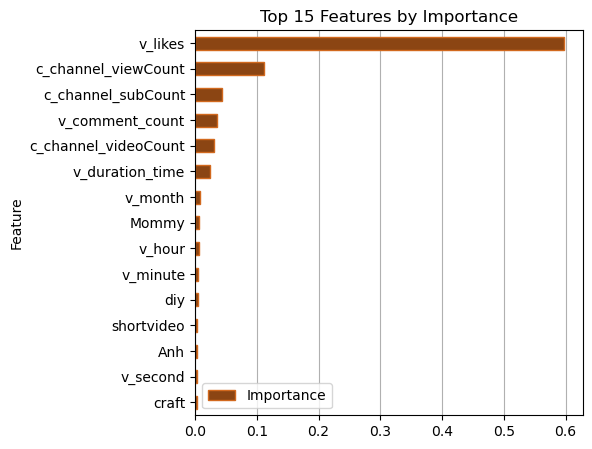

In [48]:
# Bar graph of the the Features by Importance
bars_d = importance_dfd.head(15)
bars_d = bars_d.sort_values(by='Importance', ascending=True)

bars_d.plot(
    kind='barh', 
    figsize=(5, 5),
    x='Feature',
    y='Importance',
    color='saddlebrown',
    edgecolor='chocolate',
    zorder=2,
    title='Top 15 Features by Importance'  
).grid(which='major', axis='x', zorder=4)




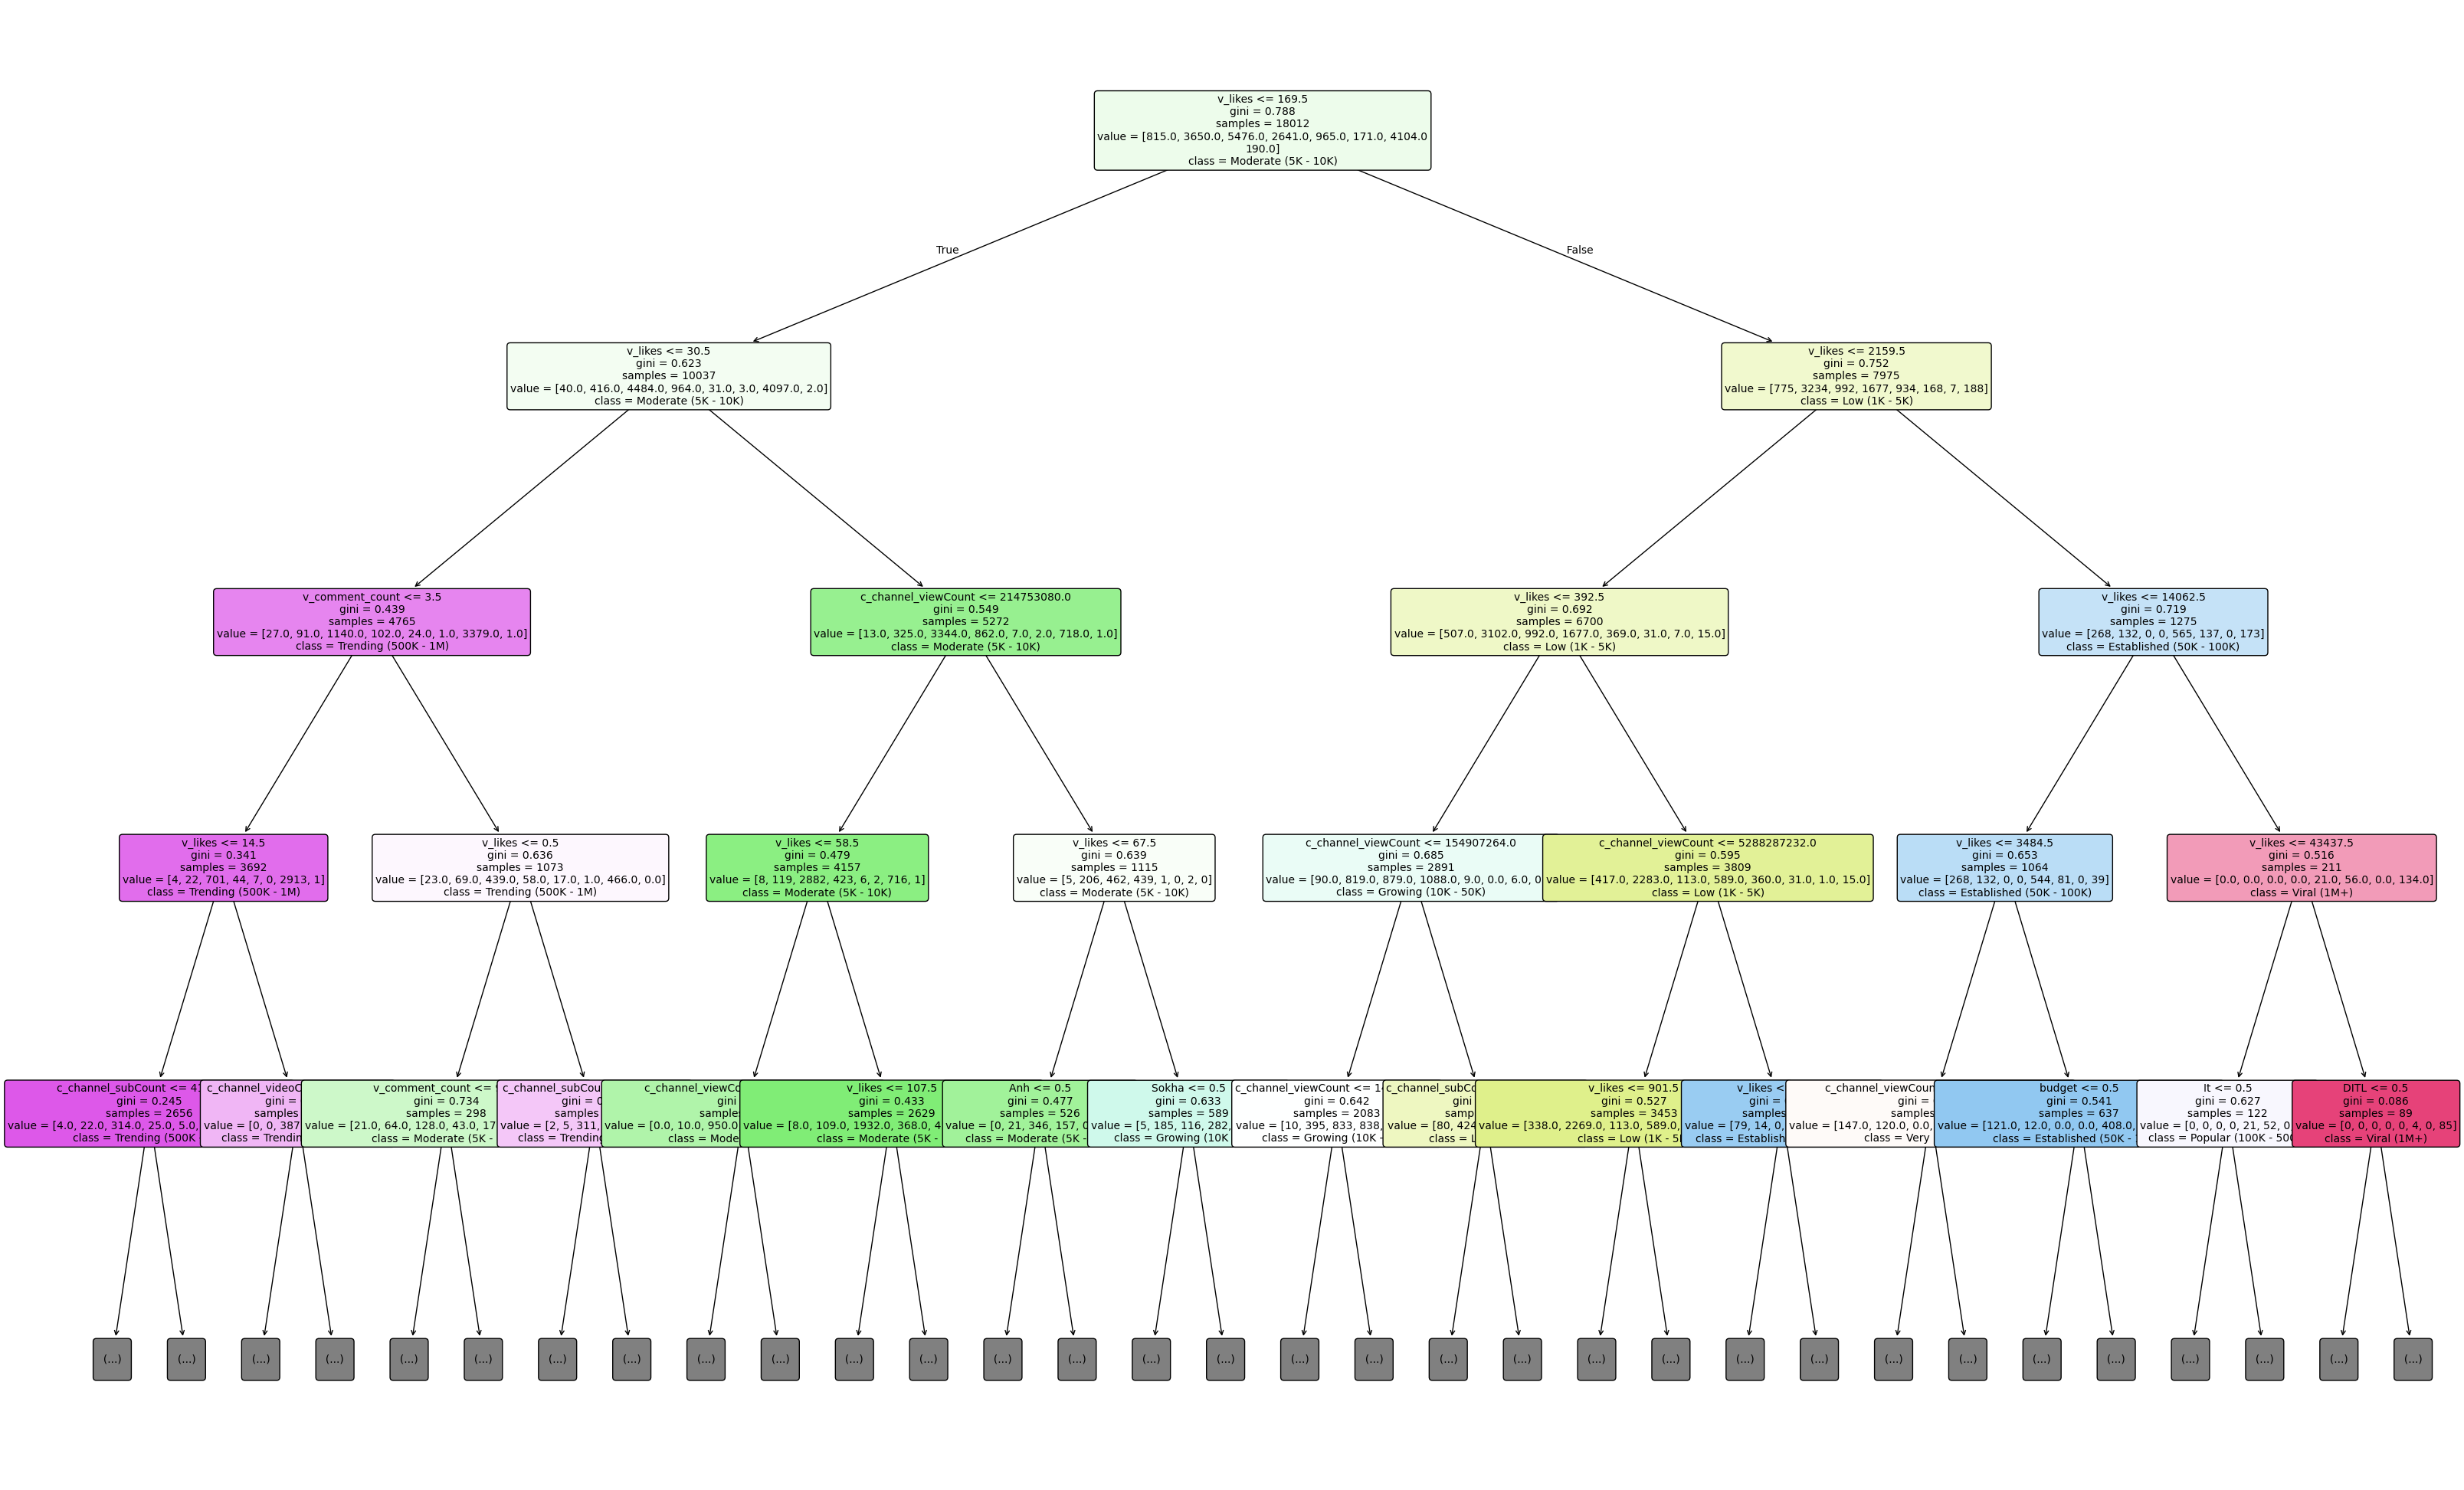

In [49]:
# Plot the decision tree
plt.figure(figsize=(40, 25))
plot_tree(modeld, 
          filled=True, 
          feature_names=l,
          class_names= ["Very Low (0 - 1K)",
        "Low (1K - 5K)",
        "Moderate (5K - 10K)",
        "Growing (10K - 50K)",
        "Established (50K - 100K)",
        "Popular (100K - 500K)",
        "Trending (500K - 1M)",
        "Viral (1M+)"],
          rounded=True, 
          fontsize=10,
          max_depth=4)
plt.show()



### Tuner used as a starting point for adjusting the Decition Tree Model
Parameters and set up were adapted from the following references:
https://www.geeksforgeeks.org/how-to-tune-a-decision-tree-in-hyperparameter-tuning/

Cell is commented out so it doesn't run by mistake, the tuner takes about two hours to run.

In [50]:

# # Define the parameter distribution
# param_dist = {
#     'criterion': ['gini', 'entropy'], 
#     'max_depth': (5,10,15,20, 25),
#     'min_samples_split': (2, 6, 10, 14),
#     'min_samples_leaf': (1,3,6,9,12), 

# random_search = RandomizedSearchCV(estimator=modeld, param_distributions=param_dist, 
#                                    n_iter=100, scoring='accuracy', cv=5, 
#                                    n_jobs=-1, verbose=2, random_state=42)

# # Fit the model
# random_search.fit(X, y)

# # Get the best parameters and best score
# best_params = random_search.best_params_
# best_score = random_search.best_score_

# print(f"Best Parameters: {best_params}"
# print(f"Best Cross-Validation Score: {best_score}")



# RANDOM FOREST

In [51]:
# Create de model
modelr = RandomForestClassifier(random_state=42, 
                                max_depth=25, 
                                max_features=None)

# Fit the Model and make Predictions
modelr.fit(X_train_combined, y_train)
y_pred = modelr.predict(X_test_combined)

# Evaluate the Model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[  93   79    4    4   44    0    0    0]
 [  22  703   40  123    5    0    3    0]
 [   0    4 1119   93    0    0  133    0]
 [   0  131  181  380    0    0    1    0]
 [  49   31    1    1  181    4    0    3]
 [   1    1    0    0   19   16    0    6]
 [   0    0  127    0    0    0  841    0]
 [   1    1    1    0   11    4    0   43]]
Accuracy Score: 0.7495559502664298
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.42      0.48       224
           1       0.74      0.78      0.76       896
           2       0.76      0.83      0.79      1349
           3       0.63      0.55      0.59       693
           4       0.70      0.67      0.68       270
           5       0.67      0.37      0.48        43
           6       0.86      0.87      0.86       968
           7       0.83      0.70      0.76        61

    accuracy                           0.75      4504
   macro avg       0.72      0.65  

In [52]:
# Feature importance
feature_importances = modelr.feature_importances_

importance_dfr = pd.DataFrame({'Feature': l, 'Importance': feature_importances})
importance_dfr = importance_dfr.sort_values(by='Importance', ascending=False)


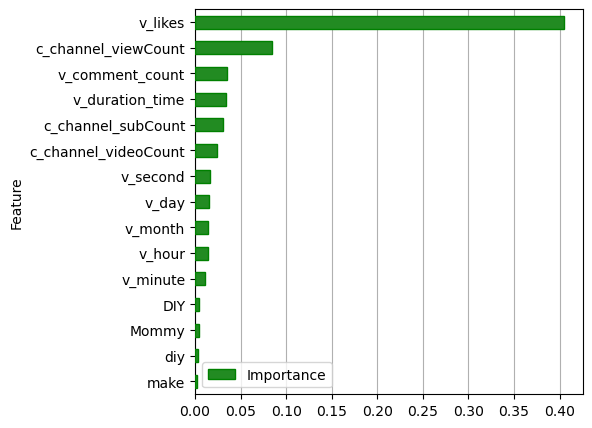

In [53]:
# Bar graph of the Feature importances
bars_f = importance_dfr.head(15)
bars_f = bars_f.sort_values(by='Importance', ascending=True)
bars_f

bars_f.plot(
    kind='barh', 
    figsize=(5, 5),
    x='Feature', 
    y='Importance',
    color = 'forestgreen',
    edgecolor='green',
    zorder=3  
).grid(which='major', axis='x', zorder=4)


### Tuner used as a starting point for adjusting the Random Forest Model
Parameters and set up were adapted from the following references:

https://stackoverflow.com/questions/64089009/how-can-i-tune-the-parameters-in-a-random-forest-classifier-inside-a-pipeline

https://www.geeksforgeeks.org/random-forest-hyperparameter-tuning-in-python/

Cell is commented out so it doesn't run by mistake, the tuner takes about two hours to run.

In [54]:
# # Set up parameter grid
# param_grid = { 
#     'n_estimators': [25, 50, 100, 150], 
#     'max_features': ['sqrt', 'log2', None], 
#     'max_depth': [5,10,15,20,25], 
#     'max_leaf_nodes': [3, 6, 9,12], 
# } 

# random_search = RandomizedSearchCV(RandomForestClassifier(), 
#                                    param_grid) 
# random_search.fit(X_train_combined, y_train) 
# print(random_search.best_estimator_) 



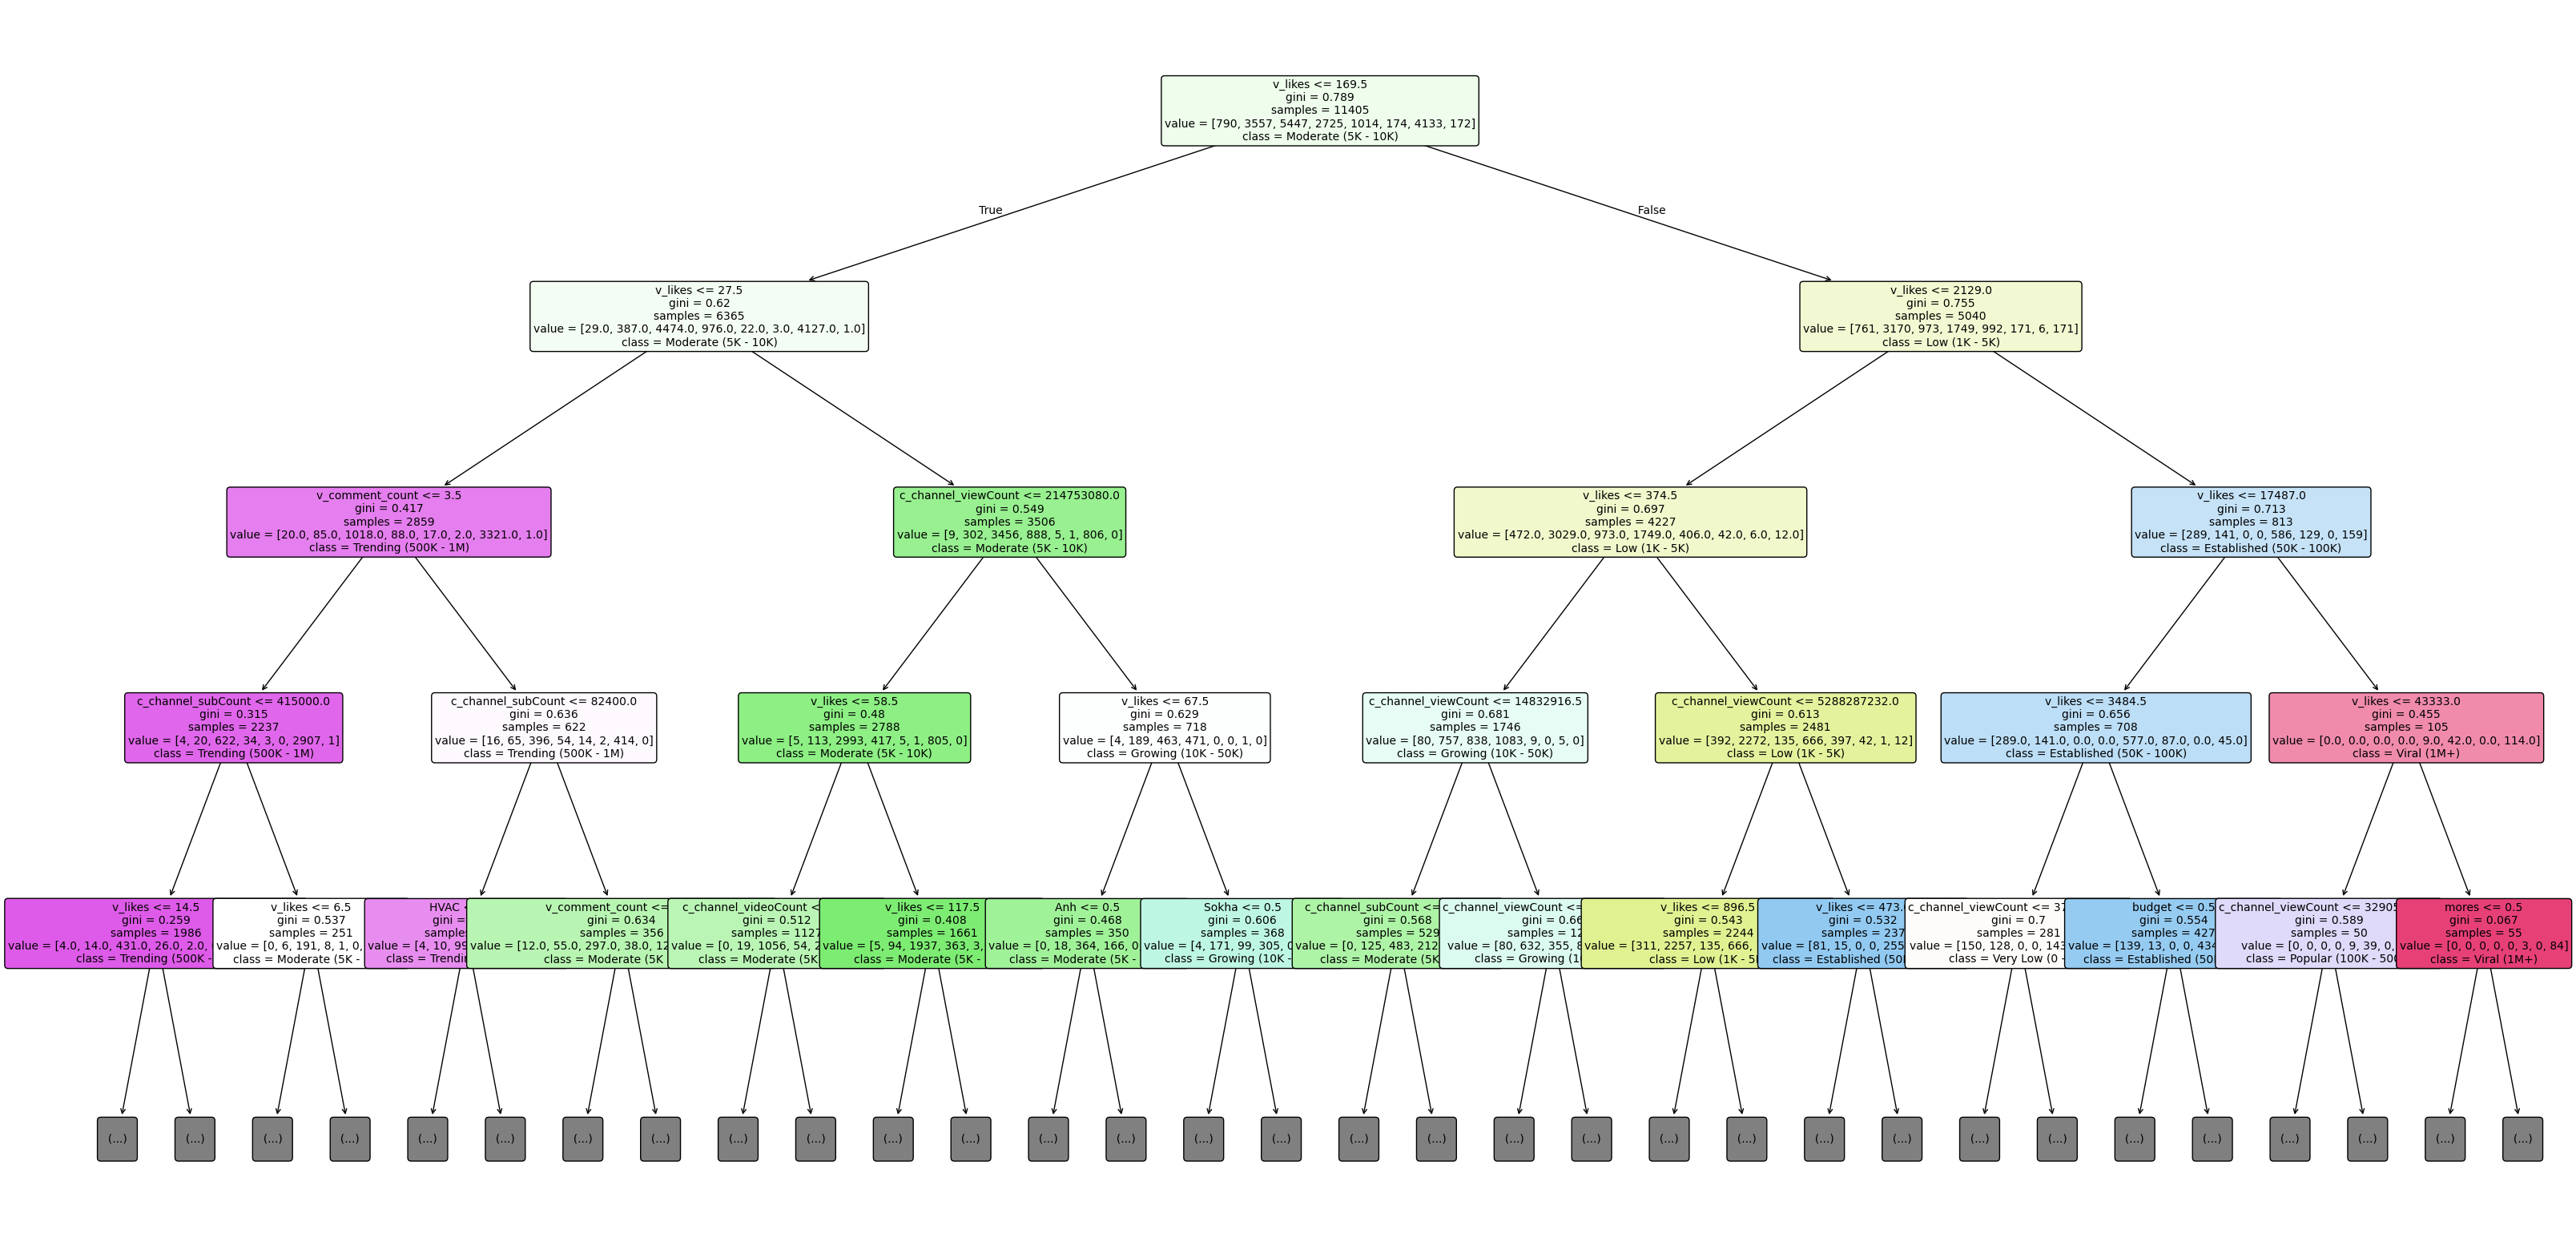

In [58]:
# Plot one of the decision trees of the model
plt.figure(figsize=(40, 20))
plot_tree(modelr.estimators_[10], 
          filled=True, 
          feature_names=l,
          class_names= ["Very Low (0 - 1K)",
        "Low (1K - 5K)",
        "Moderate (5K - 10K)",
        "Growing (10K - 50K)",
        "Established (50K - 100K)",
        "Popular (100K - 500K)",
        "Trending (500K - 1M)",
        "Viral (1M+)"],
          rounded=True, 
          fontsize=10,
          max_depth=4)
plt.show()

# XGBOOST

In [56]:
# XGB Hyperparameters
modelx = XGBClassifier(random_state = 42, 
                               subsample = 0.5, 
                                n_estimators = 600, 
                               max_depth = 15,
                               learning_rate = 0.1)

# Train the model and get predictions
modelx.fit(X_train_combined, y_train)
y_pred = modelx.predict(X_test_combined)

# Show accuracy, cofusion matric, and classification report
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.3f}%")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))



KeyboardInterrupt: 

In [ ]:
# Display top 15 Feature Importances
feature_importances = modelx.feature_importances_

importance_dfx = pd.DataFrame({'Feature': l, 'Importance': feature_importances})
importance_dfx = importance_dfx.sort_values(by='Importance', ascending=False)


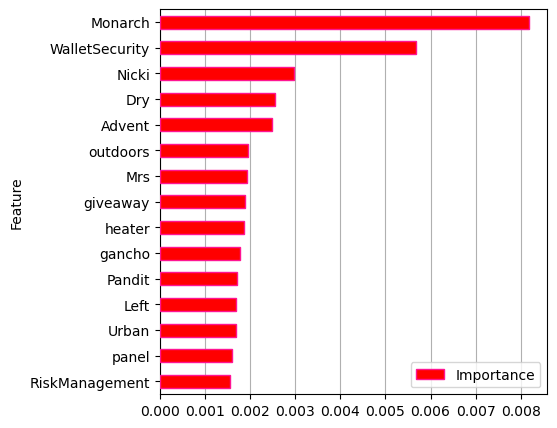

In [ ]:
# Bar graph of the Feature importances

bar_x = importance_dfx.head(15)

bar_x = bar_x.sort_values(by= 'Importance', ascending = True)

bar_x.plot(
    kind='barh', 
    figsize=(5, 5),
    x='Feature', 
    y='Importance',
    color= 'r',
    edgecolor='deeppink',
    zorder=3,
    title = 'Top 15 Features by Importance'
).grid(which='major', axis='x', zorder=4)


### Tuner used as a starting point for adjusting the XGBoost Model
Parameters and set up were adapted from the following references:
https://stackoverflow.com/questions/69786993/tuning-xgboost-hyperparameters-with-randomizedsearchcv

https://stackoverflow.com/questions/66463422/xgboost-parameter-tuning-random-search

https://medium.com/@rithpansanga/optimizing-xgboost-a-guide-to-hyperparameter-tuning-77b6e48e289d

Cell is commented out so it doesn't run by mistake, the tuner takes about two hours to run.

In [116]:
# # Define the parameter distribution
# param_dist = {
#     'max_depth': (10, 15, 20, 25),
#     'learning_rate': (0.05, 0.1),
#     'n_estimators':(100, 200, 400, 600)
# }

# # Set up RandomizedSearchCV
# random_search = RandomizedSearchCV(estimator=xgboost.XGBClassifier(), 
#                                    param_distributions=param_dist, 
#                                    n_iter=50, 
#                                    scoring='accuracy', 
#                                    random_state=42,
#                                    n_jobs = 4)

# # Fit RandomizedSearchCV
# random_search.fit(X_train_combined, y_train)

# # Get the best parameters
# print("Best hyperparameters:", random_search.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'n_estimators': 800, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.1}
